In [41]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun  4 15:40:40 2019

@author: Ethan
"""
exec(open("../util/setupConsole.py").read())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
import el_build_temp_pp_model
import gzip, pickle
import sys

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/electricity'

plotFigs = True

# only show values on the surface that have historically occurred
onlyShowObs = False

modelPower = 'pow2-noInteraction'

tempVar = 'txSummer'
qsVar = 'qsGrdcPercentileSummer'

pcVal = -2
fuelVal = -2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# load historical weather data for plants to compute mean temps 
# to display on bootstrap temp curve
fileName = '%s/script-data/entsoe-nuke-pp-tx-1981-2018.csv'%dataDirDiscovery
plantTxData = np.genfromtxt(fileName, delimiter=',', skip_header=0)
plantYearData = plantTxData[0,:].copy()
plantMonthData = plantTxData[1,:].copy()
plantDayData = plantTxData[2,:].copy()
plantTxData = plantTxData[3:,:].copy()

fileName = '%s/script-data/entsoe-nuke-pp-runoff-anom-gldas-1981-2018.csv'%dataDirDiscovery
plantQsData = np.genfromtxt(fileName, delimiter=',', skip_header=0)
plantQsData = plantQsData[3:,:]
plantQsData[plantQsData < -5] = np.nan
plantQsData[plantQsData > 5] = np.nan

summerInd = np.where((plantMonthData == 7) | (plantMonthData == 8))[0]
plantMeanTemps = np.nanmean(plantTxData[:,summerInd], axis=1)
plantMeanRunoff = np.nanmean(plantQsData[:,summerInd], axis=1)

with gzip.open('%s/script-data/ppFutureTxQsData.dat'%dataDirDiscovery, 'rb') as f:
    ppFutureData = pickle.load(f)
#     txHist = np.nanmean(np.nanmean(ppFutureData['txMonthlyMax'][:,[6,7]]))
#     qsHist = np.nanmean(np.nanmean(ppFutureData['qsAnomMonthlyMean'][:,[6,7]]))
    tx2 = np.nanmean(np.nanmean(np.nanmean(ppFutureData['txMonthlyMaxFutGMT'][1,:,:,[6,7]])))
    tx4 = np.nanmean(np.nanmean(np.nanmean(ppFutureData['txMonthlyMaxFutGMT'][3,:,:,[6,7]])))
    qs2 = np.nanmean(np.nanmean(np.nanmean(ppFutureData['qsMonthlyMeanFutGMT'][1,:,:,[6,7]])))
    qs4 = np.nanmean(np.nanmean(np.nanmean(ppFutureData['qsMonthlyMeanFutGMT'][3,:,:,[6,7]])))

In [36]:
print('building models')
models, df, plantIds, plantCooling, plantFuel, plantAge, plantUSorEU, plantYears, plantTxData, plantQsData = \
                el_build_temp_pp_model.buildNonlinearTempQsPPModel(tempVar, qsVar, 1)

ind = np.where(plantIds > 0)[0]
plantIds = plantIds[ind]
plantYears = plantYears[ind]
if pcVal == -2:
    plantCooling = plantCooling[ind]
else:
    plantCooling = [pcVal]*len(ind)
plantFuel = plantFuel[ind]
plantAge = plantAge[ind]

building models
0% complete


1.9247857621990902e-19
0.1037611781583628


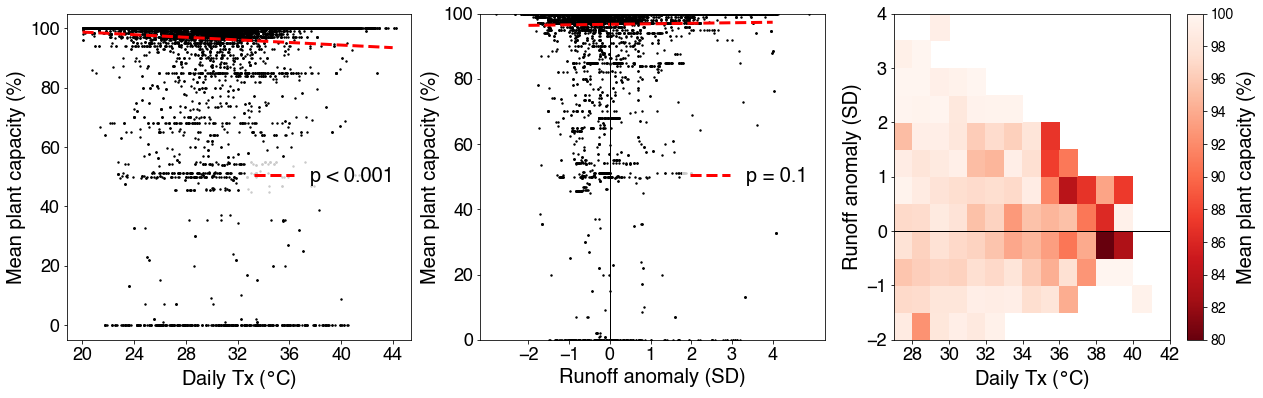

In [28]:
txbinsObs = np.arange(27,51,1)
qsbinsObs = np.arange(-4, 4.1, .5)

pcMeanObs = np.full([len(qsbinsObs), len(txbinsObs)], np.nan)

txObs = np.array(list(df['T1']))
qsObs = np.array(list(df['QS1']))
pcObs = np.array(list(df['PC']))

for qind in range(len(qsbinsObs)-1):
    for tind in range(len(txbinsObs)-1):
        inds = np.where((txObs > txbinsObs[tind]) & (txObs <= txbinsObs[tind+1]) & (qsObs > qsbinsObs[qind]) & (qsObs <= qsbinsObs[qind+1]))[0]
        if len(inds)>20:
            pcMeanObs[qind,tind] = np.nanmean(pcObs[inds])

xmax = 50
ymin = -4
ymax = 4
pcMeanObs[pcMeanObs < 80] = 80

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(21,6), nrows=1, ncols=3)


# pctx = np.nanmean(pcObs, axis=0)
nn = np.where((~np.isnan(pcObs)))[0]
X = sm.add_constant(txObs[nn])
mdlTx = sm.OLS(pcObs[nn], X).fit()

print(mdlTx.pvalues[1])

x1 = 20
x2 = 44
ax1.scatter(txObs, pcObs, color='k', s = 2)
ax1.plot([x1, x2], [mdlTx.params[0]+x1*mdlTx.params[1], mdlTx.params[0]+x2*mdlTx.params[1]], '--', color='r', lw=3, label='p < 0.001')
ax1.set_xticks(range(20, 48, 4))
ax1.set_yticks(range(0, 101, 20))
ax1.set_xlabel('Daily Tx ($\degree$C)', fontsize=20)
ax1.set_ylabel('Mean plant capacity (%)', fontsize=20)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)

l1 = ax1.legend(prop = {'size':20, 'family':'Helvetica'}, loc='center right')
l1.get_frame().set_linewidth(0)

# pcqs = np.nanmean(pcMeanObs, axis=1)
nn = np.where((~np.isnan(pcObs)))[0]
X = sm.add_constant(qsObs[nn])
mdlQs = sm.OLS(pcObs[nn], X).fit()

print(mdlQs.pvalues[1])

x1 = -2
x2 = 4
ax2.scatter(qsObs, pcObs, color='k', s = 2)
ax2.plot([x1, x2], [mdlQs.params[0]+x1*mdlQs.params[1], mdlQs.params[0]+x2*mdlQs.params[1]], '--', color='r', lw=3, label='p = 0.1')
ax2.plot([0, 0], [0, 100], '-k', lw=1)
ax2.set_yticks(range(0, 101, 20))
ax2.set_xticks(range(-2, 5, 1))
ax2.set_xlabel('Runoff anomaly (SD)', fontsize=20)
ax2.set_ylabel('Mean plant capacity (%)', fontsize=20)
ax2.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
ax2.set_ylim([0, 100])

l2 = ax2.legend(prop = {'size':20, 'family':'Helvetica'}, loc='center right')
l2.get_frame().set_linewidth(0)

a = ax3.pcolormesh(txbinsObs, qsbinsObs, pcMeanObs, cmap = 'Reds_r')
ax3.plot([27, 42], [0, 0], '-k', lw=1)
cb = fig.colorbar(a, ax=ax3)
cb.set_ticks(range(80,101,2))
cb.set_label('Mean plant capacity (%)', fontsize=20)

ax3.set_xlabel('Daily Tx ($\degree$C)', fontsize=20)
ax3.set_xticks(range(28, 43, 2))
ax3.set_ylabel('Runoff anomaly (SD)', fontsize=20)
ax3.tick_params(axis='x', labelsize=18)
ax3.tick_params(axis='y', labelsize=18)
ax3.set_ylim([-2, 4])
ax3.set_xlim([27, 42])

if plotFigs:
    plt.savefig('hist-pc-obs-%s-%s.png'%(tempVar,qsVar), format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)

In [29]:
tx25 = np.nanpercentile(np.sort(np.nanmax(plantTxData,axis=1)), 25)
qsMax25 = np.nanpercentile(np.sort(np.nanmax(plantQsData,axis=1)), 25)
qsMin25 = np.nanpercentile(np.sort(np.nanmin(plantQsData,axis=1)), 25)

AxisError: axis 1 is out of bounds for array of dimension 1

In [37]:
if 'percentile' in qsVar.lower():
    qsrange = np.linspace(0, 1, 25)
else:
    qsrange = np.linspace(-4, 4.1, 25)
txrange = np.linspace(27, 51, 25)

histPDF = np.zeros([len(qsrange), len(txrange)])
histStipple = np.zeros([len(qsrange), len(txrange)])

for q, qs in enumerate(qsrange):
    for t, tx in enumerate(txrange):
        ind = np.where((plantTxData >= tx-.5) & (plantTxData <= tx+.5) & \
                       (plantQsData >= qs-.25) & (plantQsData <= qs+.25))[0]
        if len(ind) > 0:
            histPDF[q,t] = 1
        else:
            histPDF[q,t] = 0
        
        histStipple[q,t] = len(ind)
#         if tx <= tx25 and qs >= qsMin25 and qs <= qsMax25:
#             histStipple[q,t] = 1


In [38]:
yds = np.zeros([len(models), len(qsrange), len(txrange)])
yds[yds == 0] = np.nan

print('calculating surface')
for m in range(len(models)):    
    print('model %d of %d'%(m, len(models)))
    for q in range(len(qsrange)):
        for t in range(len(txrange)):
            
            if histPDF[q,t] == 1 or not onlyShowObs:
                dfpred = pd.DataFrame({'T1':[txrange[t]]*len(plantIds), 'T2':[txrange[t]**2]*len(plantIds), \
                         'QS1':[qsrange[q]]*len(plantIds), 'QS2':[qsrange[q]**2]*len(plantIds), \
                         'QST':[txrange[t]*qsrange[q]]*len(plantIds), 'QS2T2':[(txrange[t]**2)*(qsrange[q]**2)]*len(plantIds), \
                         'PlantIds':plantIds, 'PlantYears':plantYears, 'PlantCooling':plantCooling, 'PlantAge':plantAge})

                yds[m,q,t] = np.nanmean(models[m].predict(dfpred))
            else:
                yds[m,q,t] = np.nan
        
yds = np.array(yds)
yds = np.squeeze(np.nanmedian(yds, axis=0))

calculating surface
model 0 of 1


In [39]:
minVal = 80

yds[yds<minVal] = minVal

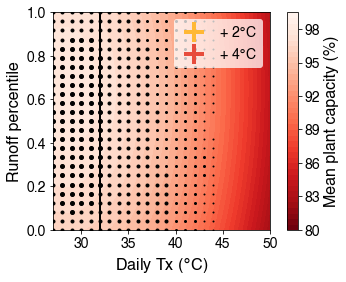

In [42]:
snsColors = sns.color_palette(["#3498db", "#e74c3c"])

xmax = 50
ymin = -4
ymax = 4

plt.contourf(txrange, qsrange, yds, levels=np.arange(minVal,100,.5), cmap = 'Reds_r')
cb = plt.colorbar()
cb.set_ticks(range(minVal,100,3))
plt.xlim([27,xmax])
if 'percentile' in qsVar.lower():
    plt.ylim([0,1])
else:
    plt.ylim([ymin,ymax])
plt.plot([27, xmax], [np.nanmean(plantMeanRunoff), np.nanmean(plantMeanRunoff)], '-k', lw=2)
plt.plot([32, 32], [ymin, ymax], '-k', lw=2)

for q in range(len(qsrange)):
    for t in range(len(txrange)):
        if histStipple[q, t] > 0:
            
            if histStipple[q, t] > 10000:
                mksz = 5
            elif histStipple[q, t] > 1000:
                mksz = 4
            elif histStipple[q, t] > 100:
                mksz = 3
            elif histStipple[q, t] > 10:
                mksz = 2
            else:
                mksz = 1
            plt.plot(txrange[t], qsrange[q], 'ok', markersize=mksz)

#plt.plot(txHist, qsHist, '+k', markersize=20, mew=4, lw=2)
plt.plot(tx2, qs2, '+k', markersize=20, mew=4, lw=2, color='#ffb835', label='+ 2$\degree$C')
plt.plot(tx4, qs4, '+k', markersize=20, mew=4, lw=2, color=snsColors[1], label='+ 4$\degree$C')

plt.xticks(np.arange(30,xmax+1,5))
# plt.yticks(qsrange)
plt.xlabel('Daily Tx ($\degree$C)', fontname = 'Helvetica', fontsize=16)
# plt.ylabel('Runoff anomaly (SD)', fontname = 'Helvetica', fontsize=16)
plt.ylabel('Runoff percentile', fontname = 'Helvetica', fontsize=16)
cb.set_label('Mean plant capacity (%)', fontname = 'Helvetica', fontsize=16)

for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontname('Helvetica')
    tick.label.set_fontsize(14)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontname('Helvetica')    
    tick.label.set_fontsize(14)
for tick in cb.ax.yaxis.get_ticklabels():
    tick.set_fontname('Helvetica')    
    tick.set_fontsize(14)

leg = plt.legend(prop = {'size':14, 'family':'Helvetica'}, loc = 'upper right', fancybox=True, framealpha=.75)
leg.get_frame().set_linewidth(0.0)

x0,x1 = plt.gca().get_xlim()
y0,y1 = plt.gca().get_ylim()
plt.gca().set_aspect(abs(x1-x0)/abs(y1-y0))

if plotFigs:
    plt.savefig('hist-pc-%s-%s-regression-contour-%s.png'%(tempVar,qsVar,modelPower), format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)
